In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from math import sqrt

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
import statsmodels.api as sm
from statsmodels.tsa.api import Holt
from seaborn import heatmap

import prepare as pr 
import acquire as ac

# acquire data

In [2]:
dfs = ac.get_superstore(ac.get_connection)

In [3]:
df = dfs

# Prep Data

In [4]:
df.head(1)

,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Segment,Country,City,State,Postal Code,Product ID,Sales,Quantity,Discount,Profit,Category ID,Region ID,Category ID.1,Category,Sub-Category,Customer ID.1,Customer Name,Product ID.1,Product Name,Region ID.1,Region Name
0,US-2015-150630,2015-09-17,2015-09-21,Standard Class,TB-21520,Consumer,United States,Philadelphia,Pennsylvania,19140.0,FUR-BO-10004834,3083.43,7.0,0.5,-1665.0522,1,4,1,Furniture,Bookcases,TB-21520,Tracy Blumstein,FUR-BO-10004834,"Riverside Palais Royal Lawyers Bookcase, Royal...",4,East


In [5]:
# Lowercase column names
df.columns = [col.lower() for col in df]

In [6]:
df.columns[0].replace(" ", "_")

'order_id'

In [7]:
for i in range(len(df.columns)): 
               if ' ' in df.columns[i]:
                   
                    new_name = df.columns[i].replace(" ", "_")
                    
                    df = df.rename(columns={df.columns[i]: new_name})
                    


In [8]:
df.head(1)

,order_id,order_date,ship_date,ship_mode,customer_id,segment,country,city,state,postal_code,product_id,sales,quantity,discount,profit,category_id,region_id,category_id.1,category,sub-category,customer_id.1,customer_name,product_id.1,product_name,region_id.1,region_name
0,US-2015-150630,2015-09-17,2015-09-21,Standard Class,TB-21520,Consumer,United States,Philadelphia,Pennsylvania,19140.0,FUR-BO-10004834,3083.43,7.0,0.5,-1665.0522,1,4,1,Furniture,Bookcases,TB-21520,Tracy Blumstein,FUR-BO-10004834,"Riverside Palais Royal Lawyers Bookcase, Royal...",4,East


In [9]:
df = df.drop(columns = ['category_id.1','customer_id.1','product_id.1','region_id.1'])

In [10]:
# creating processing time ,`ship date` from `order date`


In [11]:
df.dtypes
# quanity is a float, could be int


order_id          object
order_date        object
ship_date         object
ship_mode         object
customer_id       object
segment           object
country           object
city              object
state             object
postal_code      float64
product_id        object
sales            float64
quantity         float64
discount         float64
profit           float64
category_id        int64
region_id          int64
category          object
sub-category      object
customer_name     object
product_name      object
region_name       object
dtype: object

In [12]:
numerical = df.select_dtypes(include= 'number')
num_cols = numerical.columns.tolist()

In [13]:
len(df.columns)

22

In [14]:
len(num_cols)

7

In [15]:
categoricals = df.select_dtypes(include= 'object')
cat_cols = categoricals.columns.tolist()

In [16]:
len(cat_cols)

15

# Numerical Explore

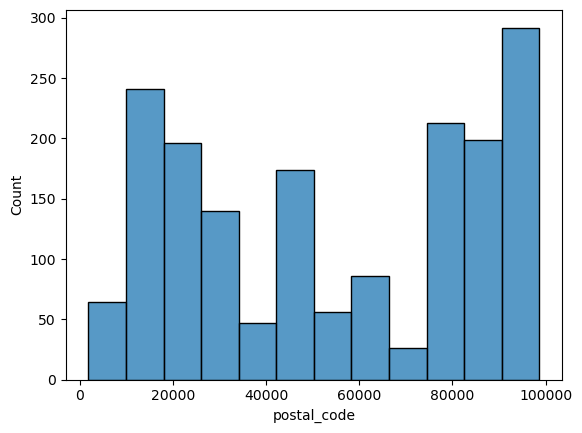

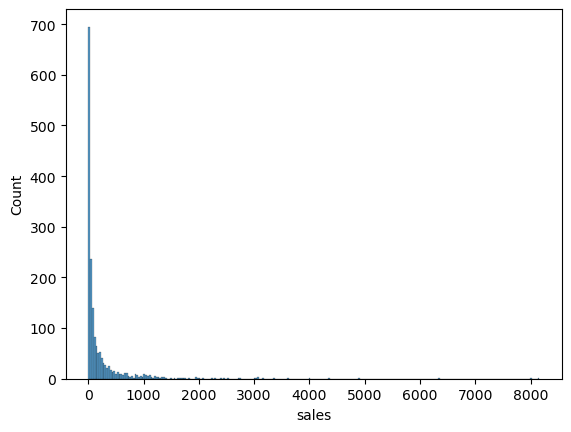

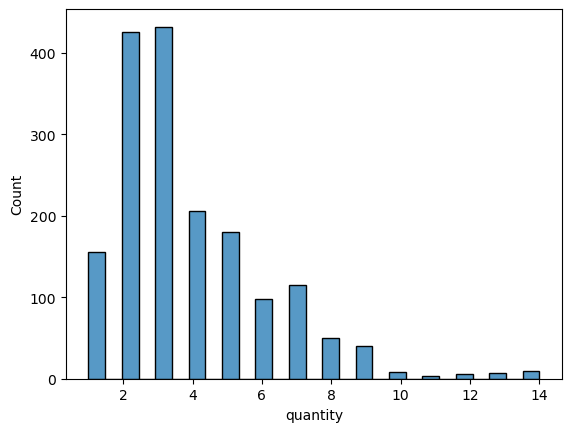

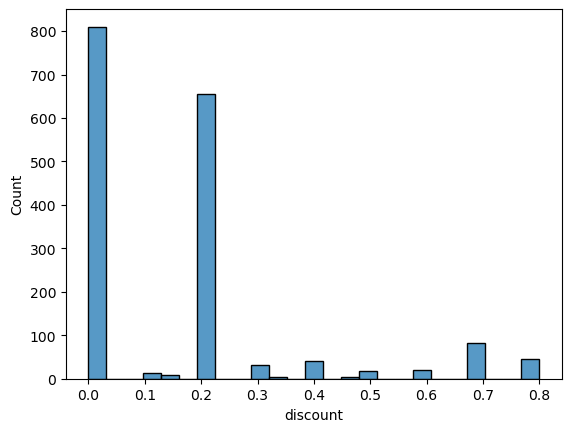

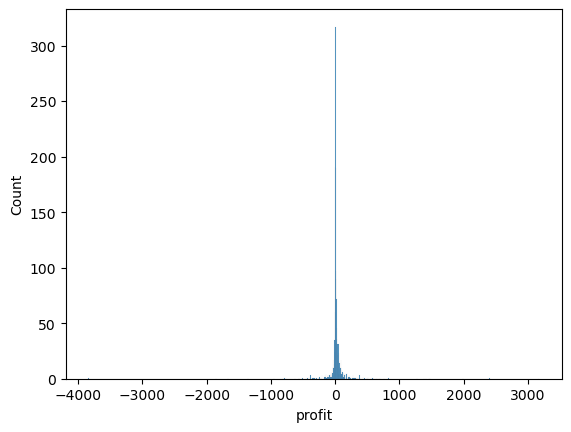

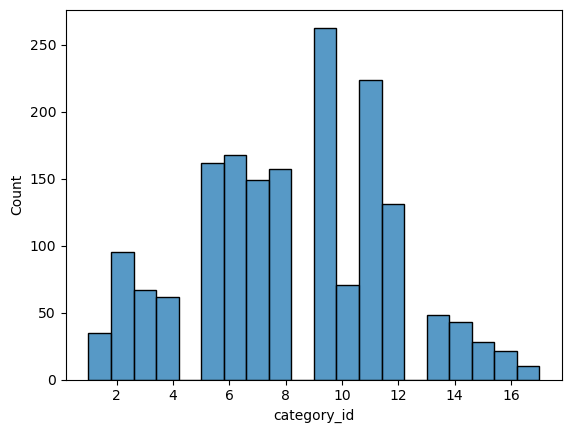

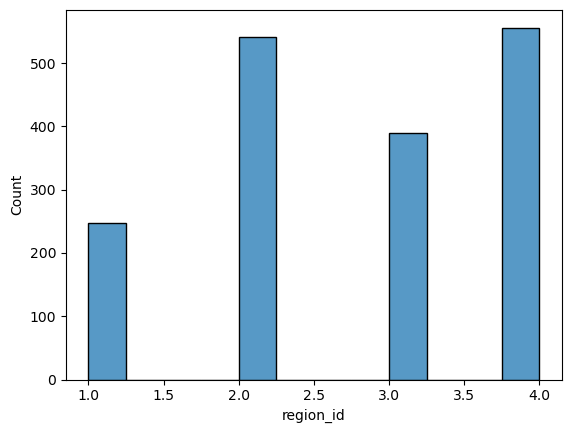

In [17]:
for col in numerical.columns:
    sns.histplot(data = numerical, x = col)
    plt.show()

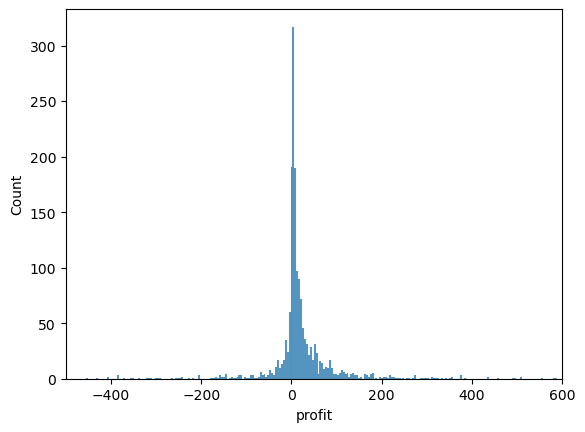

In [18]:
# print chart zoomed in.
sns.histplot(data = numerical, x = 'profit')
plt.xlim(-500,600)
plt.show()

In [19]:
# maybe i recommend to stop selling items that are costing us money

# Categorical

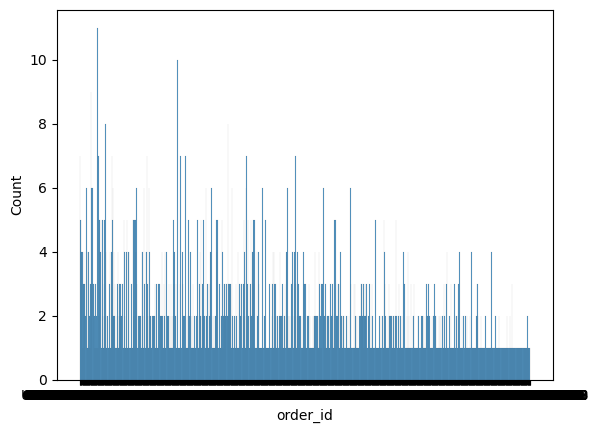

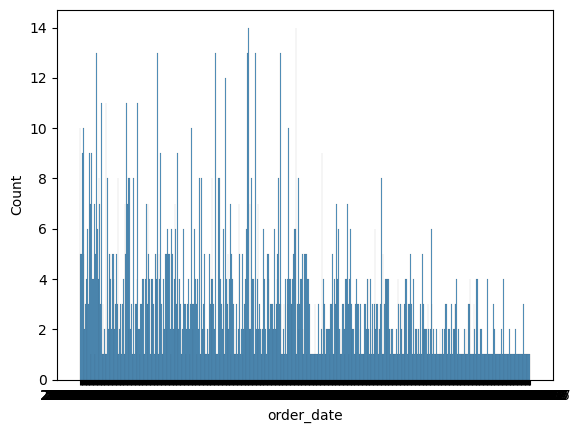

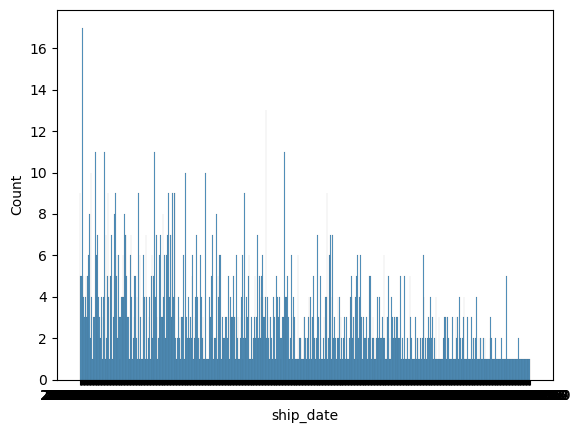

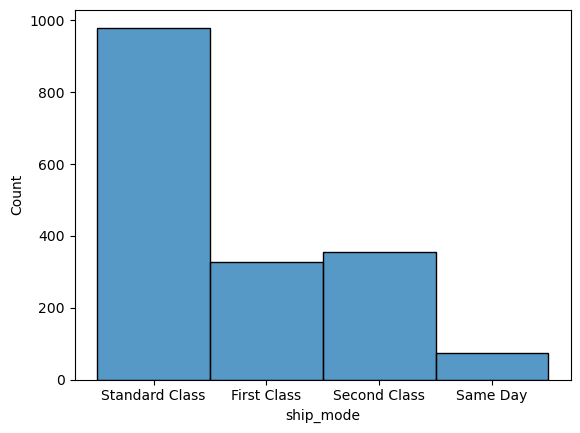

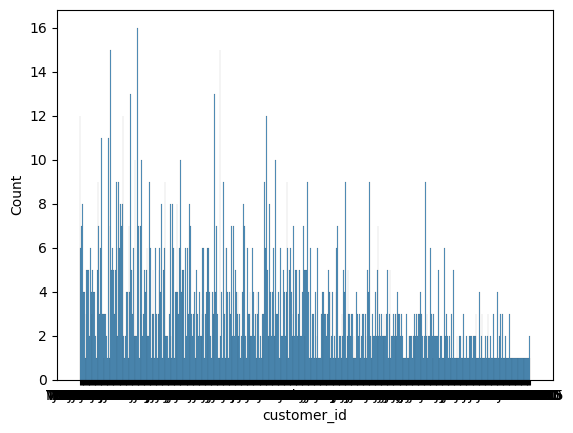

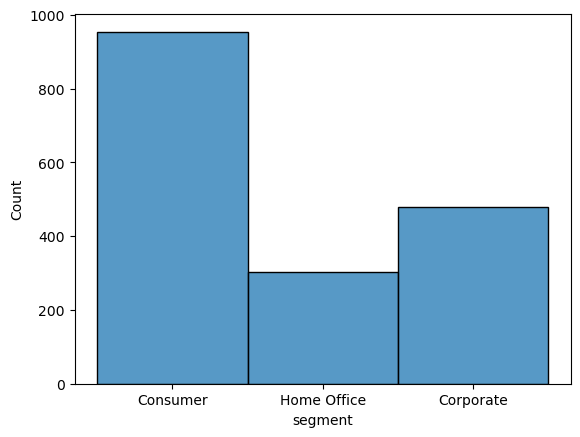

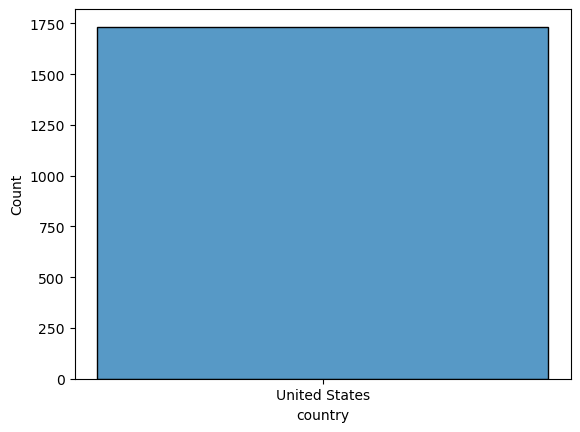

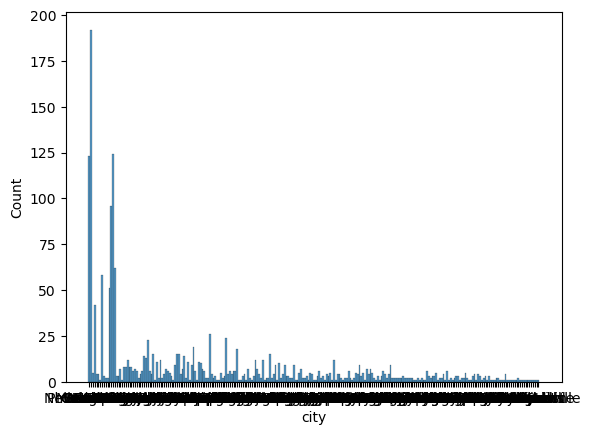

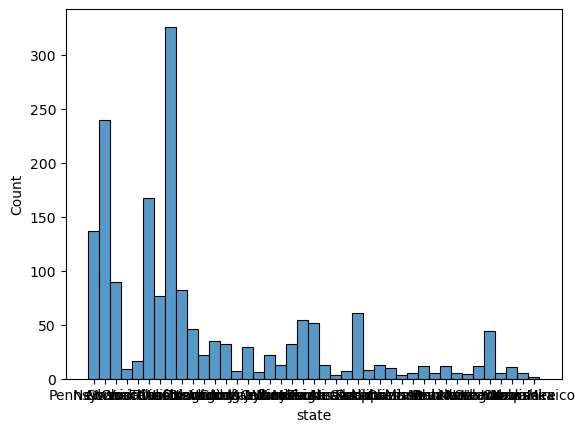

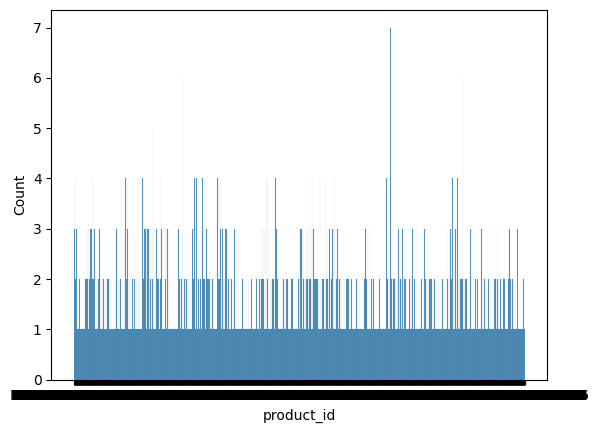

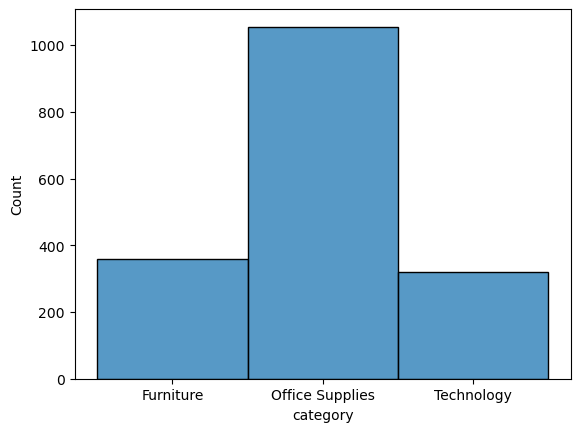

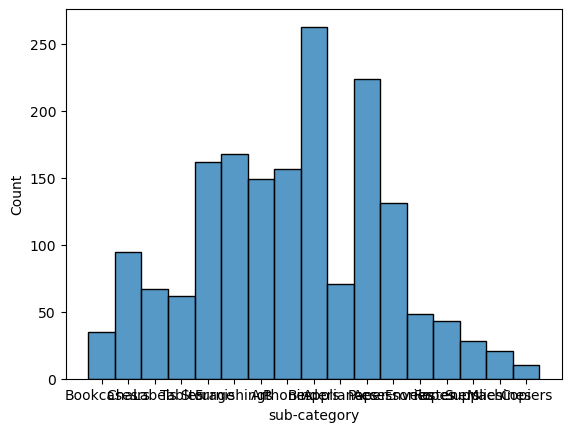

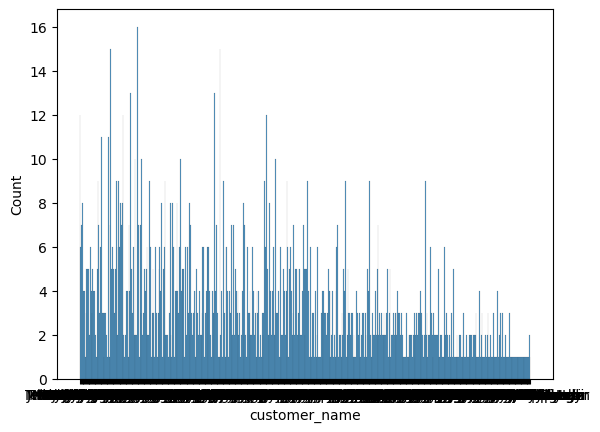

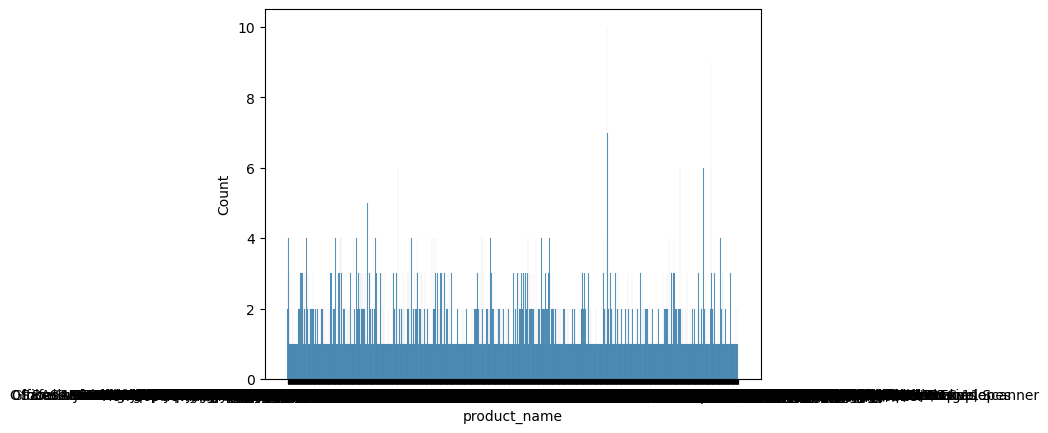

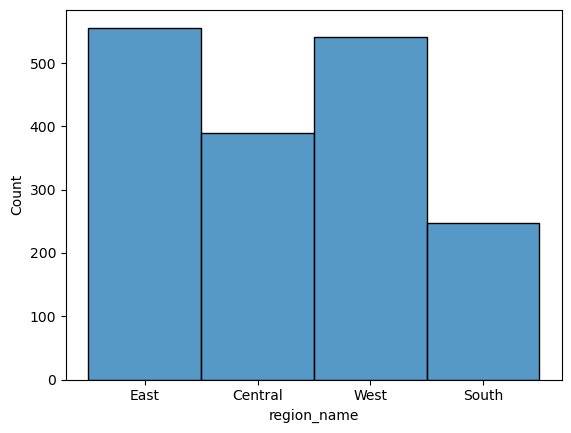

In [20]:
for col in categoricals.columns:
    sns.histplot(data = categoricals, x = col, bins = 100)
    plt.show()

<div class="alert alert-block alert-info">
<b>Overall:</b> Worst of Product: Which product line should we cut out?
        
- Is there a product category that is particularly not profitable for us? 

- Does one or another stand out in terms of sales volume? 

- Does this vary by customer segment?

- Can i predict a profitable vs non-profitable product based one certain features

</div>

# mulit-vars plot

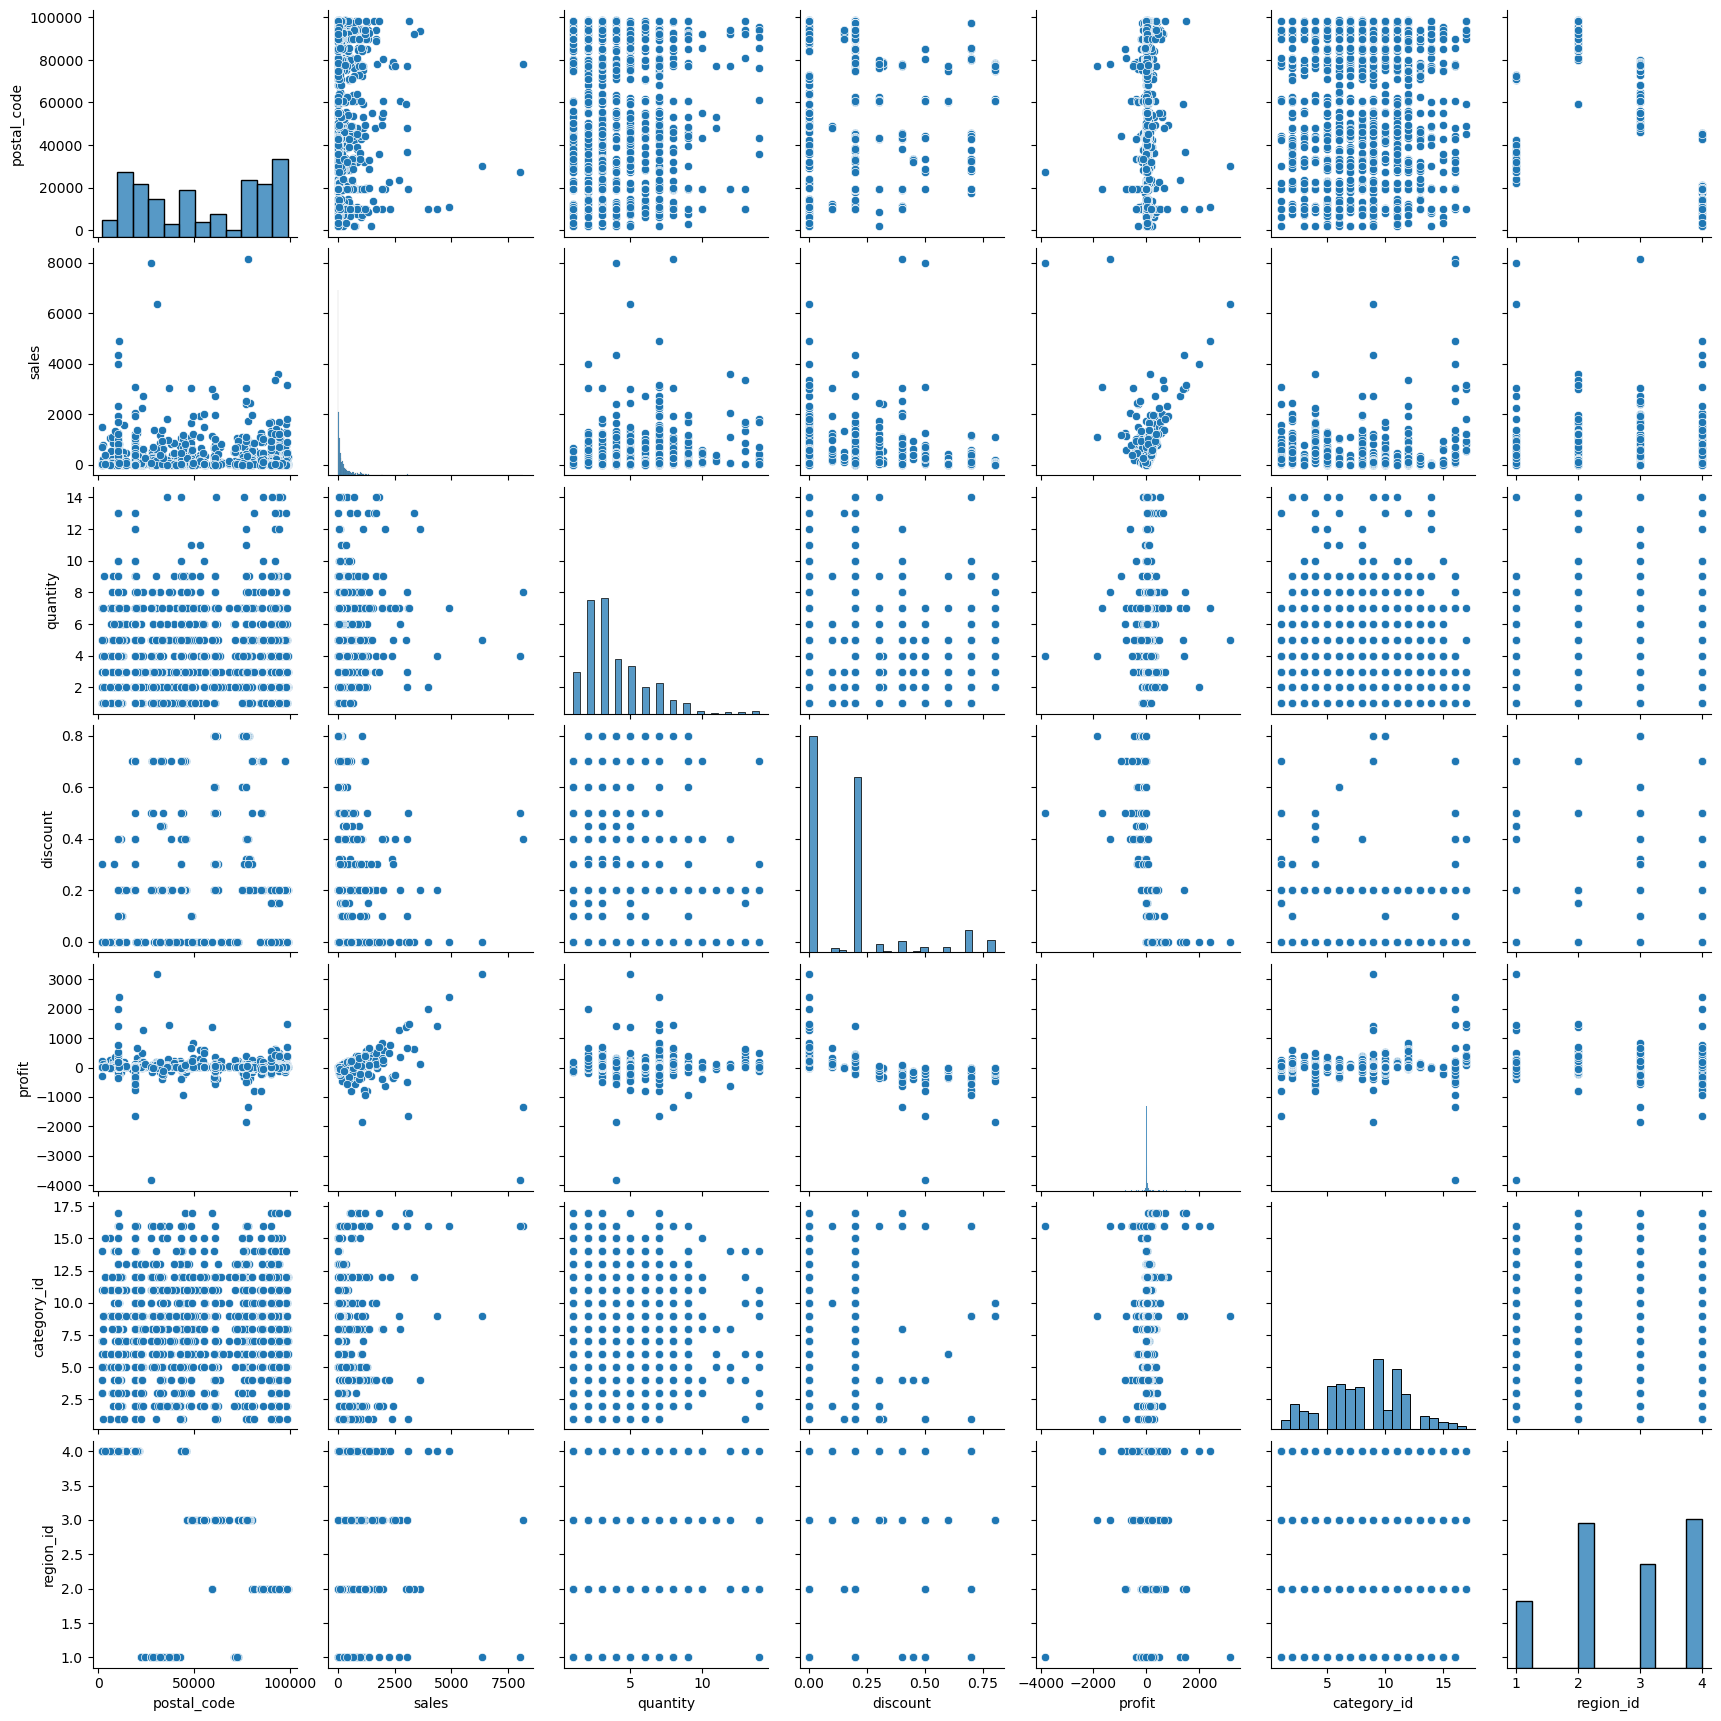

In [21]:
sns.pairplot(data = df)

<AxesSubplot:>

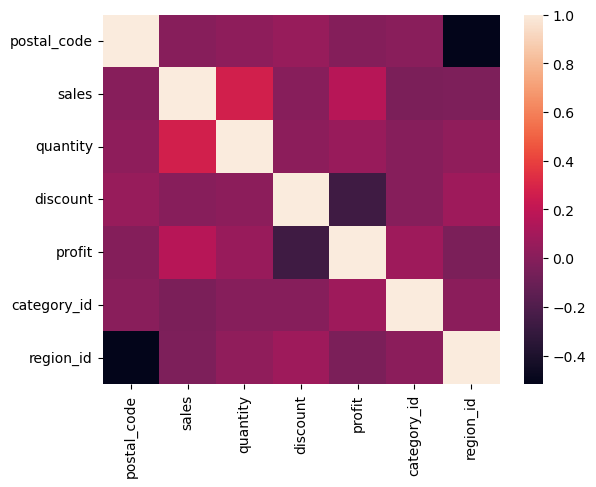

In [22]:
heatmap(df.corr())

In [23]:
df.corr()

,postal_code,sales,quantity,discount,profit,category_id,region_id
postal_code,1.000000,-0.001044,0.023043,0.056851,-0.013018,0.009152,-0.518115
sales,-0.001044,1.000000,0.268102,0.001564,0.167875,-0.038117,-0.036838
quantity,0.023043,0.268102,1.000000,0.015634,0.061512,-0.007016,0.027486
discount,0.056851,0.001564,0.015634,1.000000,-0.264722,-0.006522,0.080296
profit,-0.013018,0.167875,0.061512,-0.264722,1.000000,0.075269,-0.038896
category_id,0.009152,-0.038117,-0.007016,-0.006522,0.075269,1.000000,0.010151
region_id,-0.518115,-0.036838,0.027486,0.080296,-0.038896,0.010151,1.000000


In [24]:
# profit has a negative correlation with region_id, postal_code, and DISCOUNT
# discount has a positive correlation with postal code and region_id (region .08 and postal .05)
# these may cause discount to go up which causes profit to go down.

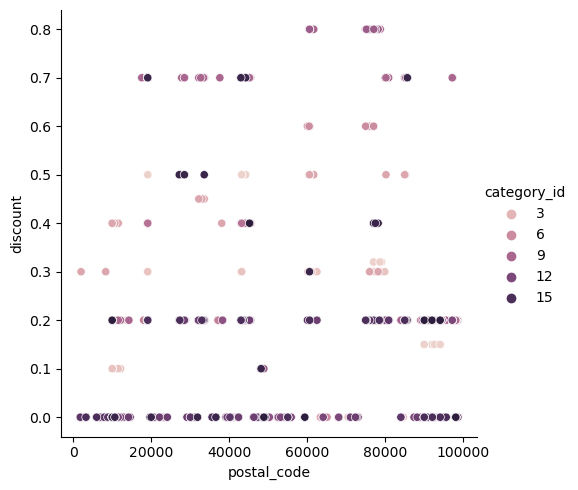

In [25]:
sns.relplot(data = df, x = 'postal_code',y = 'discount',hue = 'category_id')

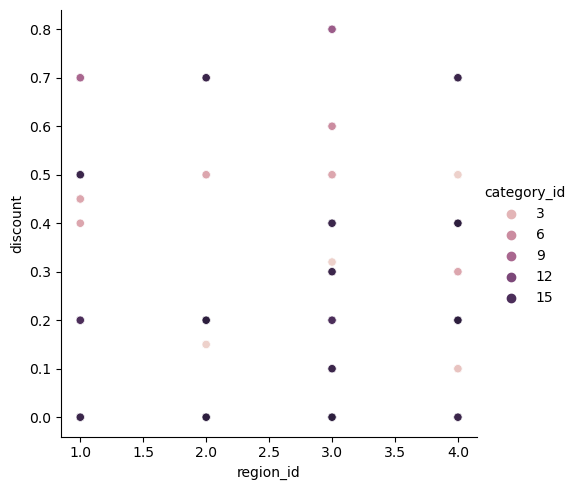

In [26]:
sns.relplot(data = df, x = 'region_id',y = 'discount',hue = 'category_id')

In [27]:
df[df.region_id == 1].profit.sum(),df[df.region_id == 1].discount.mean()

(8581.551, 0.13891129032258048)

In [28]:
df[df.region_id == 2].profit.sum(),df[df.region_id == 2].discount.mean()

(18382.550699999996, 0.12107208872458458)

In [29]:
df[df.region_id == 3].profit.sum(),df[df.region_id == 3].discount.mean()

(483.3866999999941, 0.2307969151670955)

<div class="alert alert-block alert-info">
Region is 3 has the LEAST amount of profit, the Highest Discount

In [30]:
df[df.region_id == 4].profit.sum(),df[df.region_id == 4].discount.mean()

(10493.040899999998, 0.15809352517985675)

<div class="alert alert-block alert-info">
Lets look at what is being discounted

In [31]:
reg3 = df[df.region_id == 3] 

In [32]:
reg3ds = reg3[reg3.discount > 0]

<AxesSubplot:xlabel='discount', ylabel='Count'>

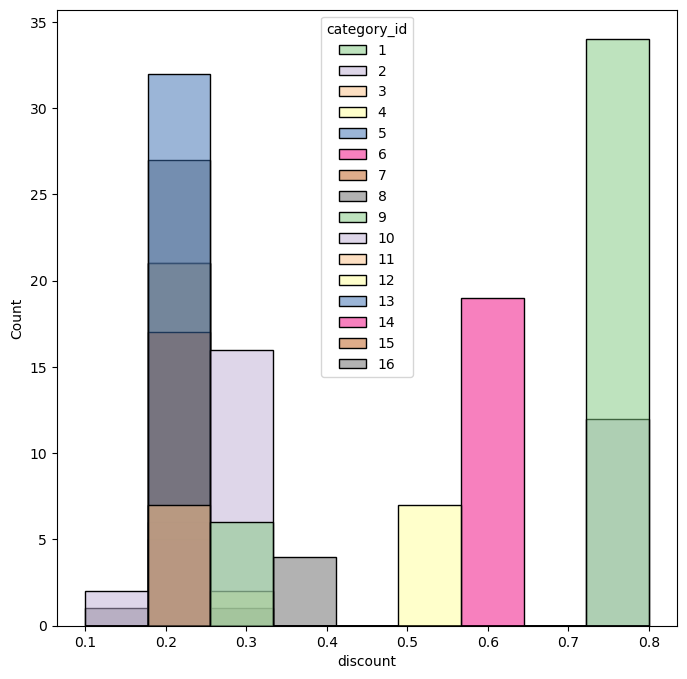

In [33]:
plt.figure(figsize = (8,8)) 
sns.histplot(data= reg3ds, x = 'discount',hue= 'category_id',palette= 'Accent') 


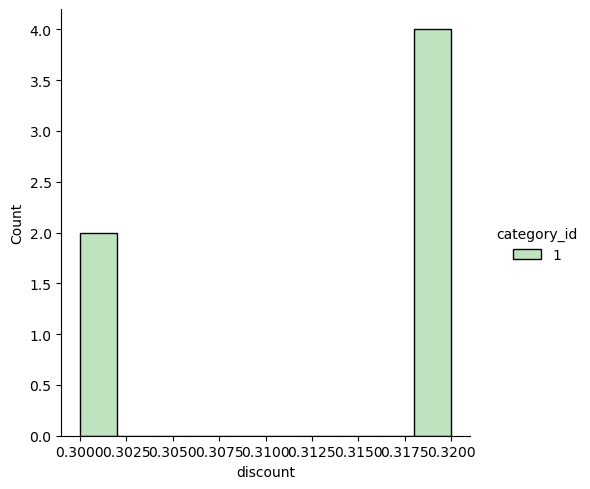

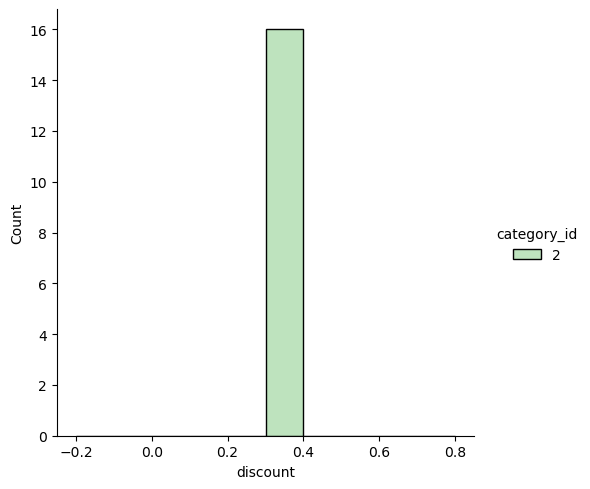

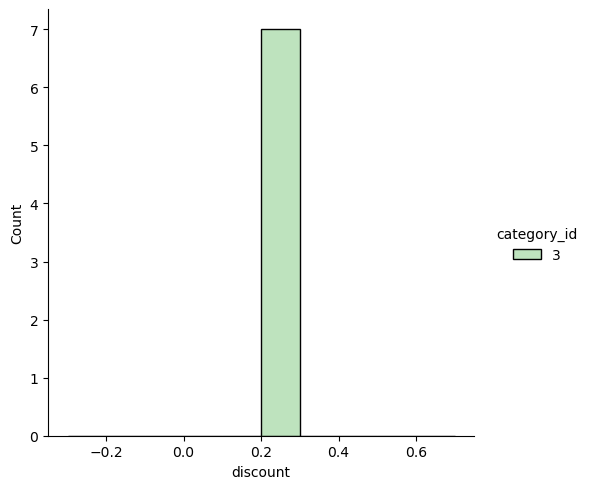

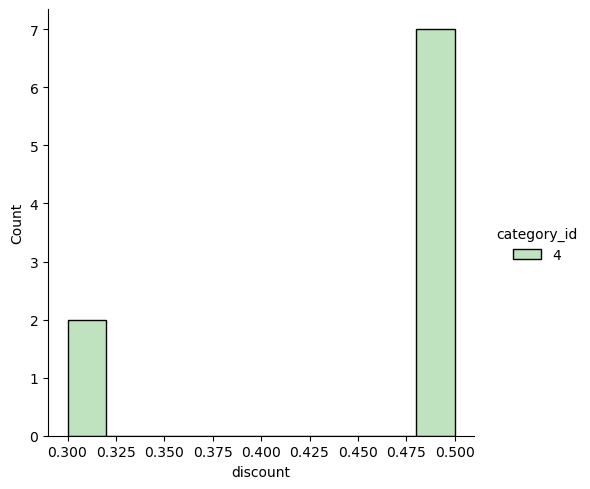

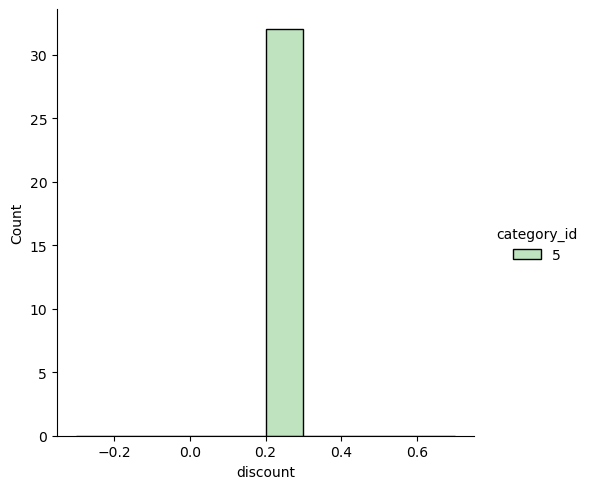

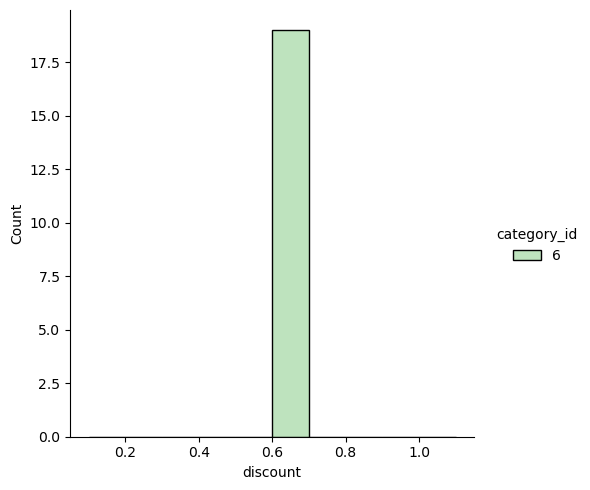

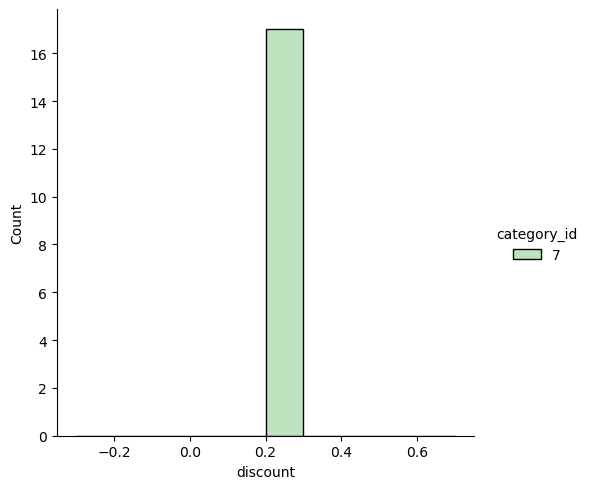

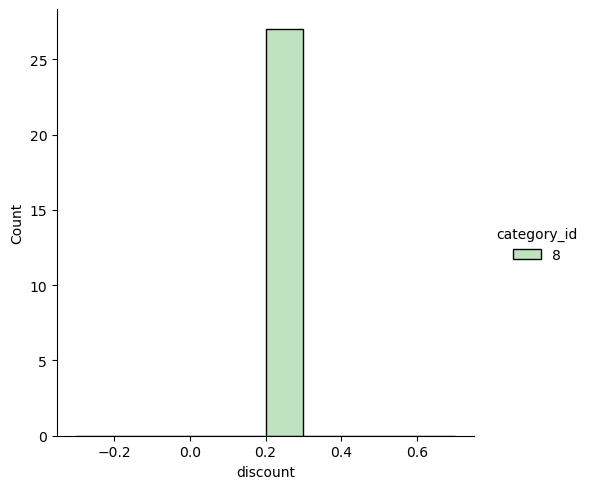

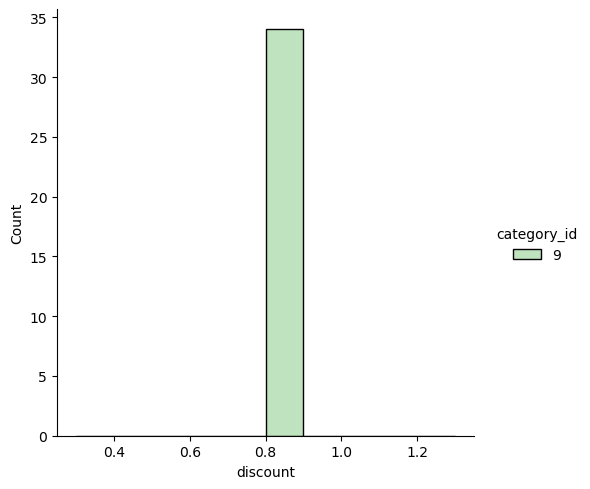

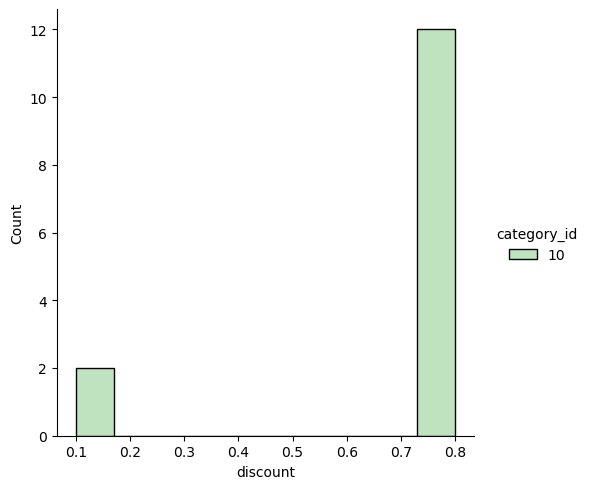

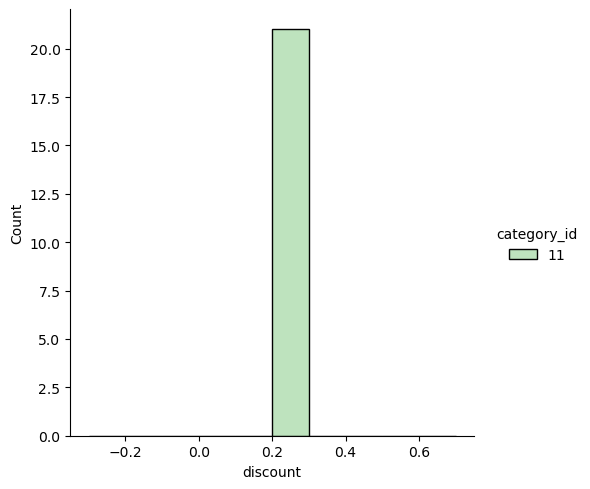

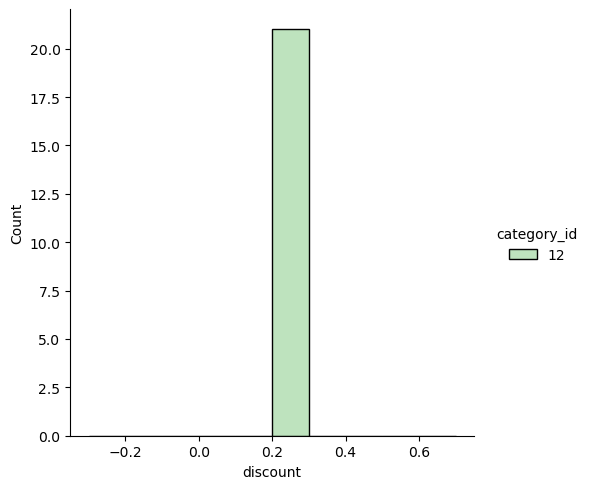

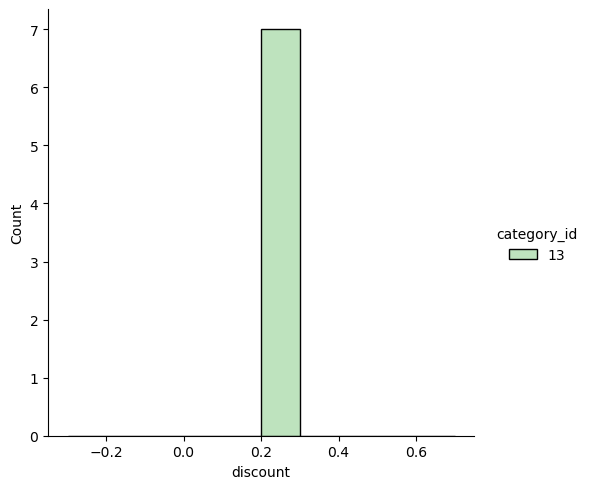

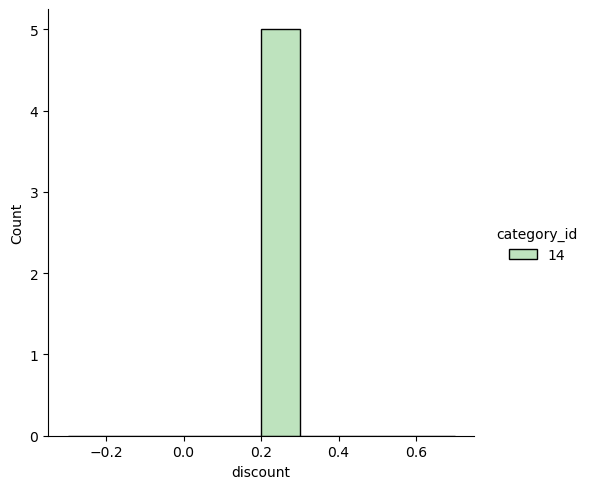

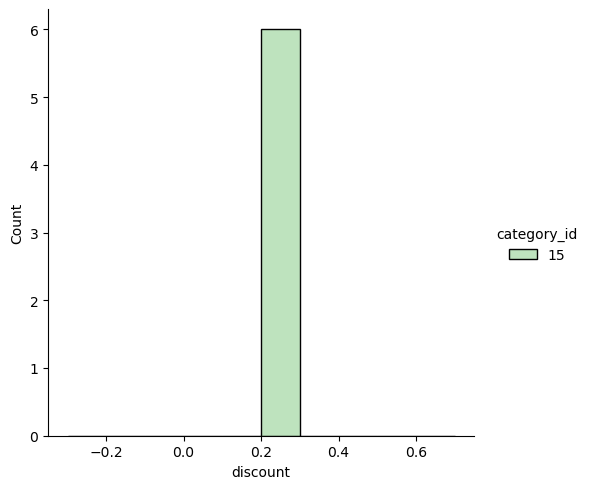

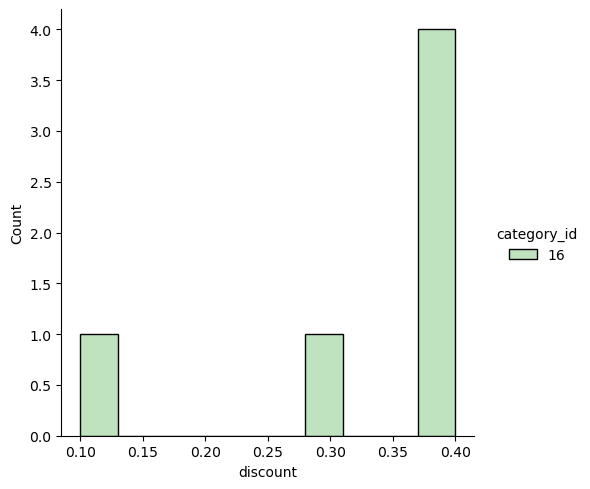

In [34]:
for i in range (1,17):
    test=reg3ds[reg3ds.category_id == i]
    sns.displot(data= test, x = 'discount',hue= 'category_id',palette= 'Accent',bins = 10) 
    plt.show()

In [35]:
# category 1 has alot of discounts in the .32 range
# category 9 has all their discounts in .8
# category 6 .6 ish
# category 10 has alot in .8
# category 16, .40


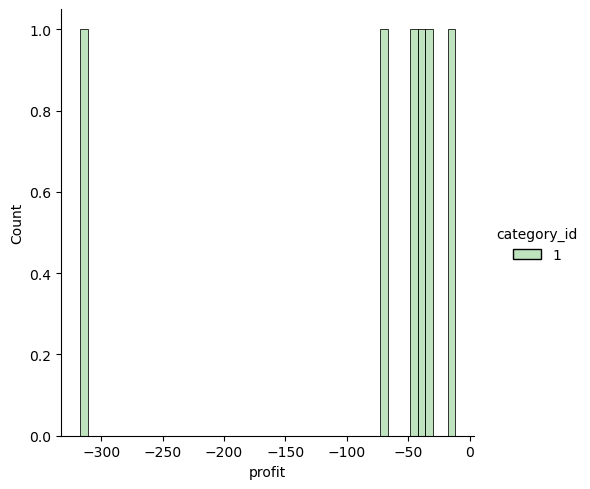

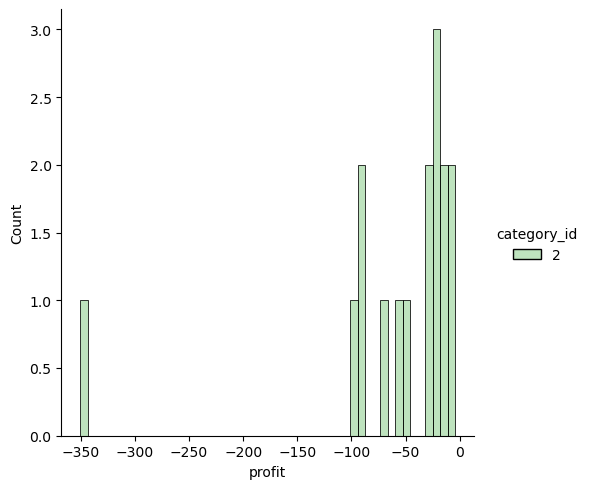

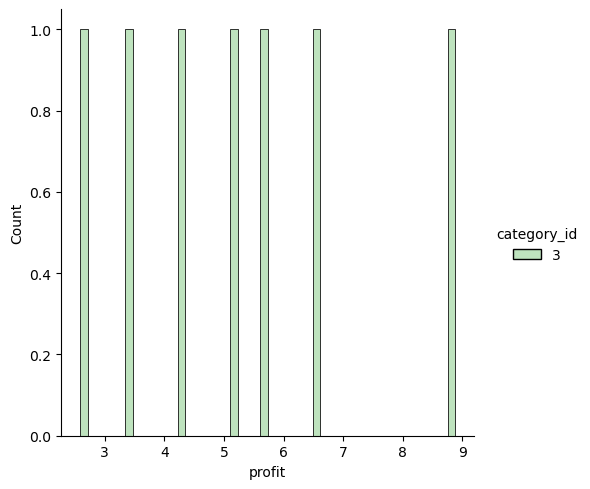

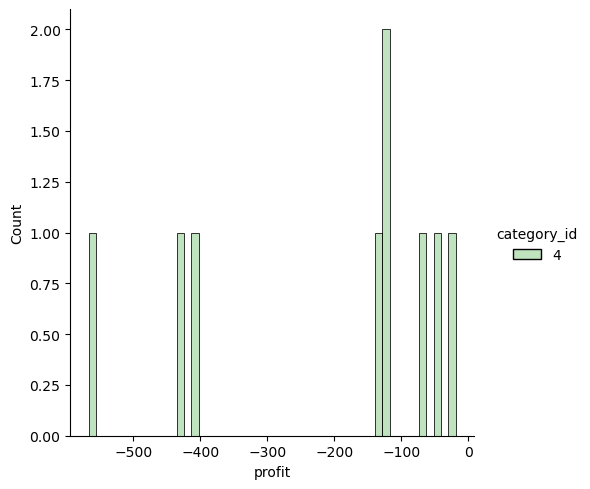

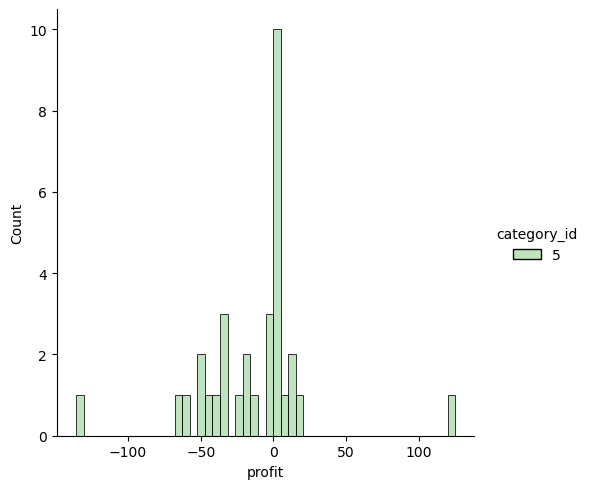

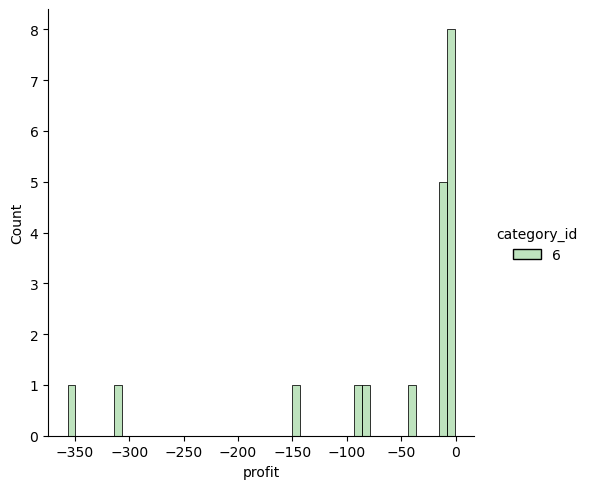

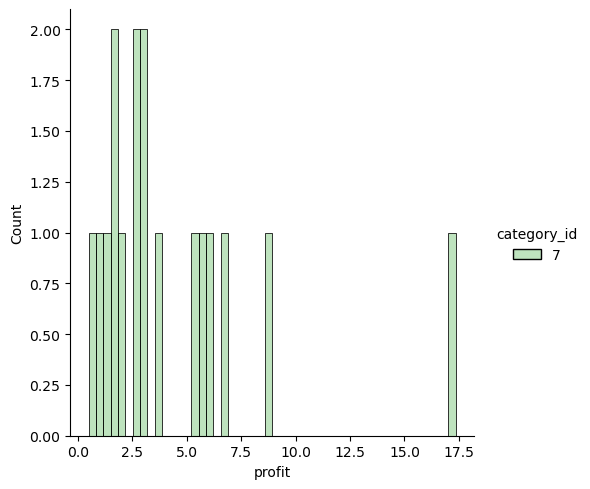

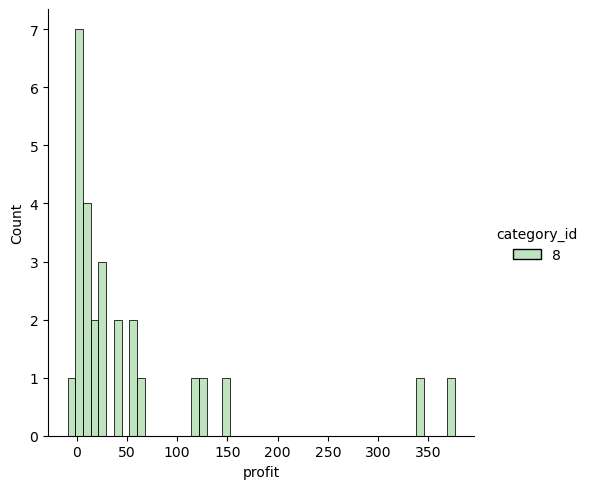

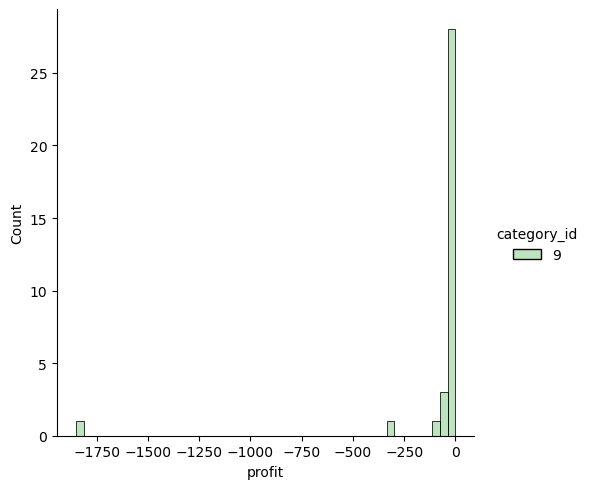

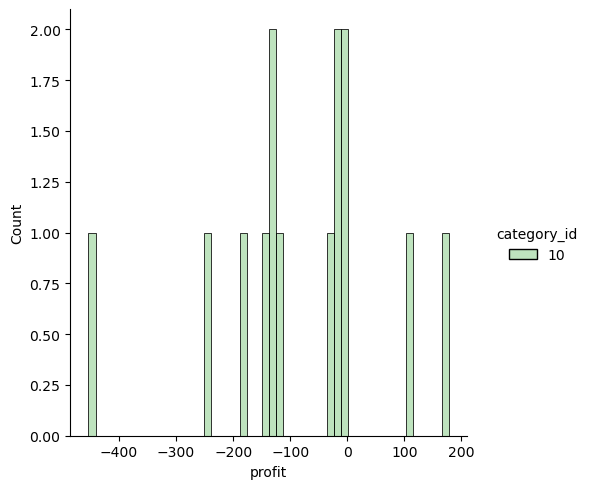

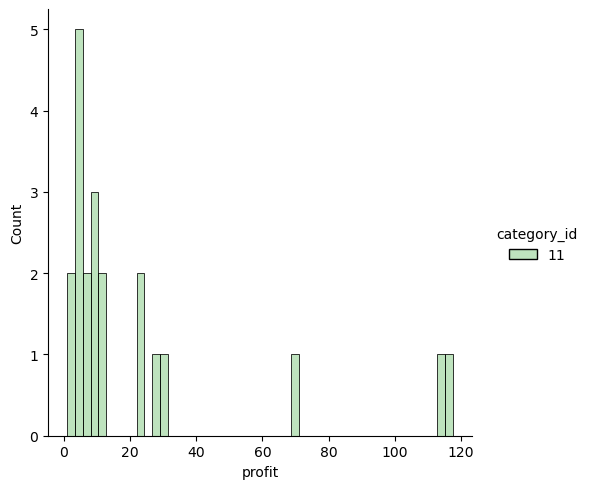

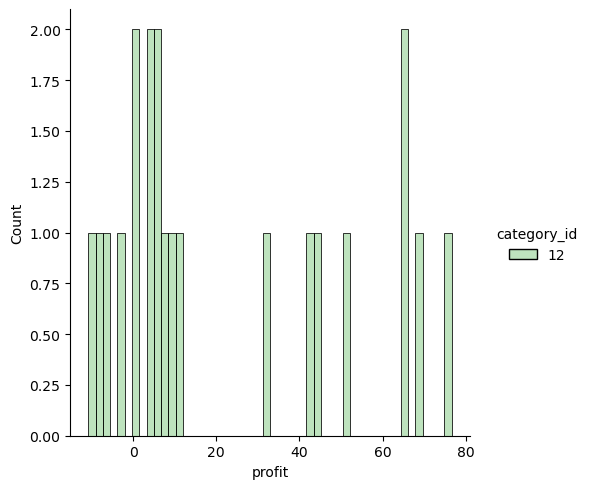

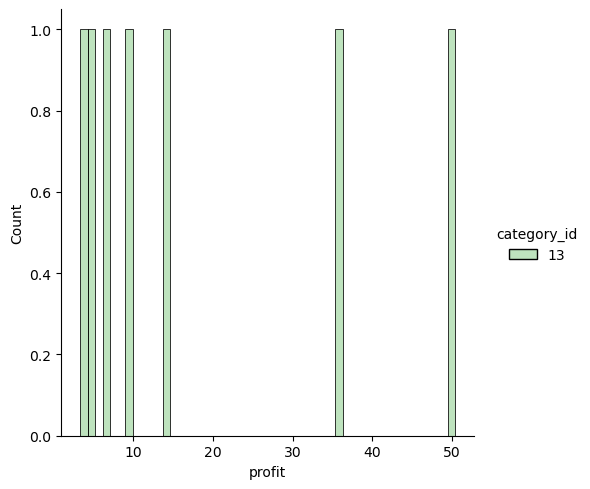

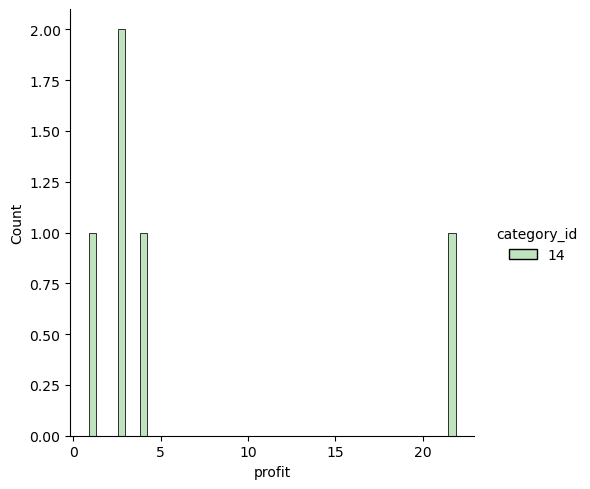

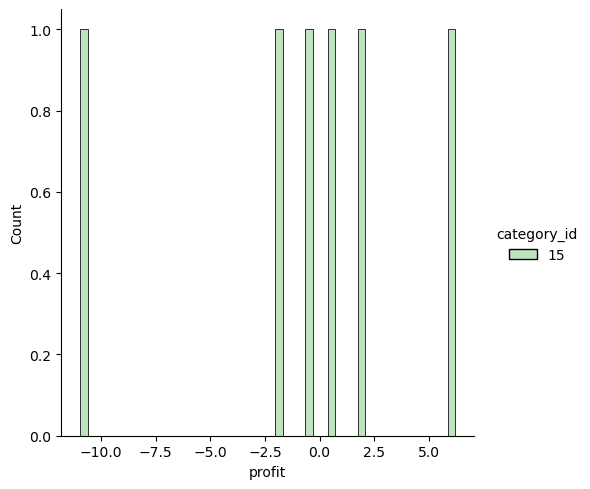

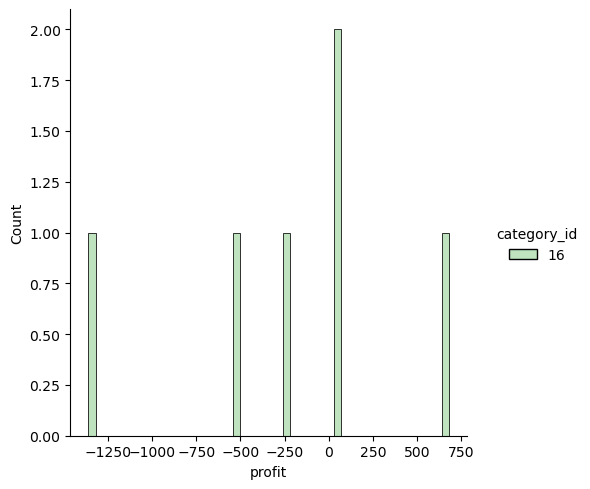

In [36]:
for i in range (1,17):
    test=reg3ds[reg3ds.category_id == i]
    sns.displot(data= test, x = 'profit',hue= 'category_id',palette= 'Accent',bins = 50) 
    plt.show()

In [37]:
for i in range (1,17):
    print(i)
    print( )
    prof = reg3ds[reg3ds.category_id == i].profit.sum()
    print(prof) 
    

1

-519.6778000000002
2

-966.3732000000002
3

36.561099999999996
4

-1908.0485000000003
5

-410.92450000000036
6

-1121.0558999999996
7

73.87249999999996
8

1538.4263999999994
9

-2743.1937000000016
10

-1188.5548000000003
11

495.6132999999999
12

464.2284999999999
13

123.88919999999997
14

32.187
15

-4.255000000000013
16

-1353.921700000003


In [38]:
# category 1 has alot of discounts in the .32 range
# category 9 has all their discounts in .8
# category 6 .6 ish
# category 10 has alot in .8
# category 16, .40

#-------------

# cat 16, -1353
# cat 4, -1908
# cat 6, -1121
# cat 9, -2743
# cat 10, -1188

# Setting Datetime

In [39]:
# treat this as our time span of data
df.order_date.min(),df.order_date.max()

('2014-01-04', '2017-12-30')

In [40]:
df.order_date = pd.to_datetime(df.order_date)

In [41]:
df.ship_date = pd.to_datetime(df.ship_date)

In [42]:
df = df.set_index('order_date').sort_index()

# Explore datetime

In [44]:
df_sam = df[['sales','profit']]

In [45]:
# this data frame holds our target, profit. also holds sales
df_sam

,sales,profit
order_date,,
2014-01-04,272.7360,-64.7748
2014-01-04,3.5400,-5.4870
2014-01-04,11.7840,4.2717
2014-01-09,31.2000,9.7500
2014-01-09,9.3440,1.1680
2014-01-10,2.8900,1.3583
2014-01-10,51.9400,21.2954
2014-01-11,9.9400,3.0814
2014-01-13,646.7400,258.6960


In [46]:
train_size = int(len(df_sam) * .5)
validate_size = int(len(df_sam) * .3)
test_size = int(len(df_sam) - train_size - validate_size)
validate_end_index = train_size + validate_size

# split into train, validation, test
train = df_sam[: train_size]
validate = df_sam[train_size : validate_end_index]
test = df_sam[validate_end_index : ]

In [47]:
train

,sales,profit
order_date,,
2014-01-04,272.7360,-64.7748
2014-01-04,3.5400,-5.4870
2014-01-04,11.7840,4.2717
2014-01-09,31.2000,9.7500
2014-01-09,9.3440,1.1680
2014-01-10,2.8900,1.3583
2014-01-10,51.9400,21.2954
2014-01-11,9.9400,3.0814
2014-01-13,646.7400,258.6960


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


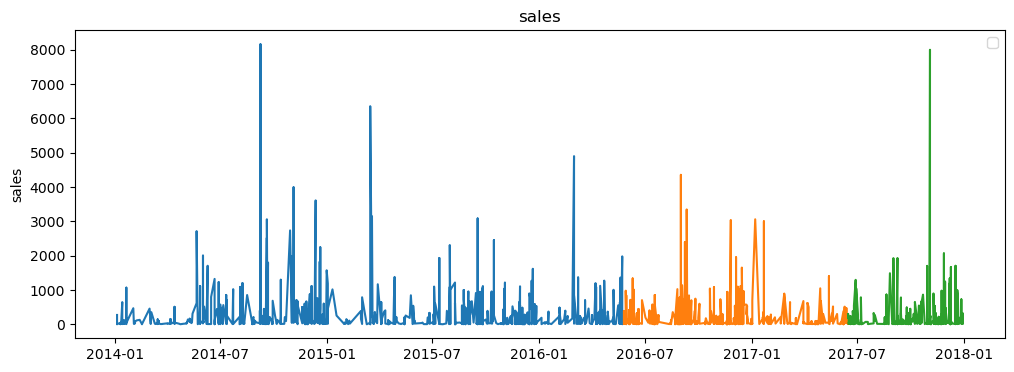

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


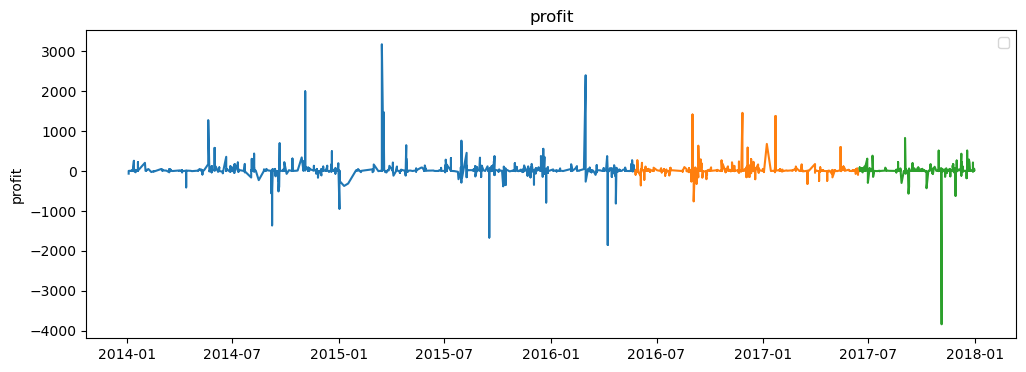

In [48]:
for col in train.columns:
    plt.figure(figsize=(12,4))
    plt.plot(train[col])
    plt.plot(validate[col])
    plt.plot(test[col])
    plt.ylabel(col)
    plt.legend()
    plt.title(col)
    plt.show()

In [ ]:
# 


# Is there an area where some categories aren't selling or discount more than usual? that is particularly not profitable for us?

In [ ]:
# category 9, 4,10,16, are not profitable in region 3. let's see how much over time.

# sales and profit corr

In [ ]:
df[['sales','profit']].corr()

# .corr if profit was only positive

In [ ]:
ppdf = df[df.profit > 0]

In [ ]:
ppdf[['sales','profit']].corr()

In [ ]:
len(ppdf)

# negative profit

In [ ]:
ndf = df[df.profit < 0]

In [ ]:
len(ndf)

In [ ]:
sns.histplot(data = ndf, x = 'profit')

#  .corr if profit we removed products that were less that -400 profitable

In [ ]:
bestdf = df[df.profit > -400]

In [ ]:
bestdf[['sales','profit']].corr()

In [ ]:
# Is there a product category that is particularly not profitable for us?

In [ ]:
ndf['loss_per_unt'] = ndf.profit % ndf.quantity

In [ ]:
 neg = ndf.product_id.tolist()

In [ ]:
for i in range(0,len(df)):
    if df.product_id[i] in neg:
        if df.profit[i] > 0:
            print(f'{df.product_id[i]} has a positive value')
    

In [ ]:
df[df.product_id == 'FUR-BO-10002613']

In [ ]:
df[df.product_id == 'FUR-BO-10004834']

In [ ]:
for col in df.columns:
    sns.relplot(x = col,y= df.profit, data =df)
    

# Does one more another stand out in terms of sales volume?

# Does this vary by customer segment?

# Can i predict a profitable vs non-profitable product based one certain features